## Define paths


In [1]:
path = 'datasets/'
flickr_path = path+'Flickr_Data/'

## Import Libraries

In [2]:
import re
import json
import collections

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import nltk
from nltk.corpus import stopwords
import string
from time import time
import pickle
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
#from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from keras.models import Model, load_model
from keras.utils.data_utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merging import add

# DATA EXTRACTION

## 1. Exctracting all the captions from token.txt 

In [4]:
with open(flickr_path+"Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [5]:
captions = captions.split("\n")[:-1]

In [6]:
len(captions)

40460

In [7]:
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [8]:
descriptions = {}
for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []
    descriptions[img_name].append(cap)

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## 2. Preprocess captions by removing irrelavant characters

In [10]:
def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ",sample)
    sample = sample.split()
    sample = [s for s in sample if len(s)>1]
    sample = " ".join(sample)
    return sample

In [11]:
clean_text("Hello worsdafl sin fnjnef %3275def 125 fefnjca >>4t5 fnej CJEWNJQ s ")

'hello worsdafl sin fnjnef def fefnjca fnej cjewnjq'

In [12]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])
    

In [13]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## 3. Creating txt file to convert the captions to json strings


In [14]:
f = open("descriptions.txt",'w')
f.write(str(descriptions))
f.close()

In [15]:
f = open("descriptions.txt",'r')
descriptions = f.read()
f.close()

json_acceptable_stirng = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_stirng)


## 4. Creating a dictionary of all the words, retaining those with frequency more than 10

In [16]:
vocabulary = set()
for key in descriptions.keys():
  [vocabulary.update(i.split()) for i in descriptions[key]]

print("Unique words: %d" % len(vocabulary))

Unique words: 8424


In [17]:
all_vocab = []

for key in descriptions.keys():
  [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words: %d" % len(all_vocab))
print(all_vocab[:15])

Total Words: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [18]:
import collections

counter = collections.Counter(all_vocab)
dic_ = dict(counter)
threshold_value = 10
sorted_dic = sorted(dic_.items(),reverse=True,key=lambda x:x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshold_value]
all_vocab = [x[0] for x in sorted_dic]


In [19]:
len(all_vocab)

1845

## 5. Extracting training and test images, only file names without extension 

In [20]:
f = open(flickr_path+"Flickr_TextData/Flickr_8k.trainImages.txt")
train = f.read()
f.close()


In [21]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [22]:
f = open(flickr_path+"Flickr_TextData/Flickr_8k.testImages.txt")
test = f.read()
f.close()


In [23]:
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

## 6. Creating training dictionary with Image-Caption pair. One image has 5 captions 

In [24]:
train_descriptions = {}
for t in train:
    train_descriptions[t]  = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)
    

In [25]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## 7. Plotting training images with captions

In [26]:
images = flickr_path+"Images/"
uni_filenames = [e for e in open(flickr_path+"Flickr_TextData/Flickr_8k.trainImages.txt").read().split("\n")[:-1]]

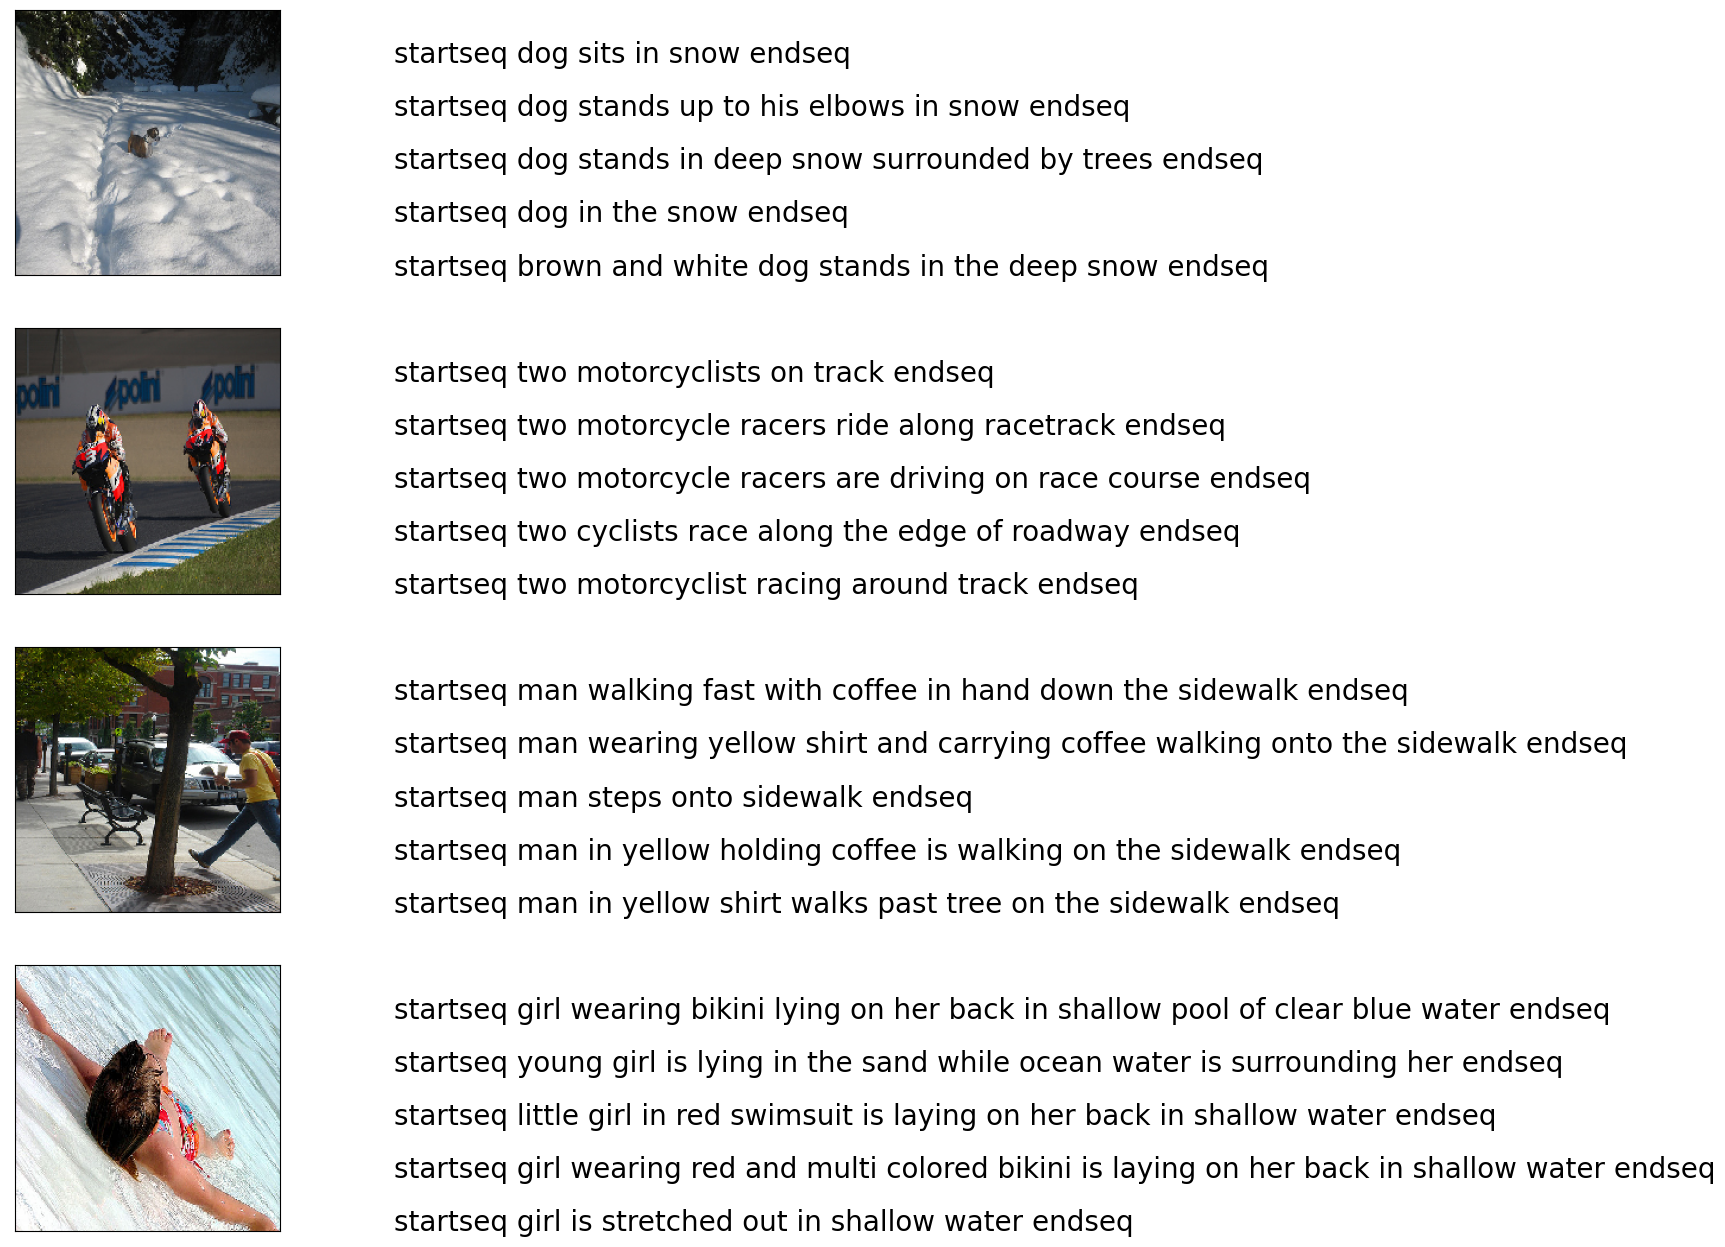

In [27]:
import random
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

n = random.randint(0,6000)
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[n:n+4]:
    filename = images + '/' + jpgfnm
    captions = train_descriptions[jpgfnm.split(".")[0]]
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## 8. Creating word to index mapping and vice versa. 

In [28]:
i = 1
word_to_idx = {}
idx_to_word = {}

for word in all_vocab:
    word_to_idx[word] = i
    idx_to_word[i] = word
    i += 1

index = len(word_to_idx)
word_to_idx['startseq'] = index+1
word_to_idx['endseq'] = index+2

idx_to_word[index+1] = 'startseq'
idx_to_word[index+2] = 'endseq'

vocab_size = len(idx_to_word) + 1

print(len(word_to_idx))
print(len(idx_to_word))
print(vocab_size)

1847
1847
1848


## 9. Calculating max_length possible for a caption

In [29]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)


35


 ## 10. Creating word embeddings using Glove Dataset

In [30]:
golve_path ='./datasets/glove.6B.200d.txt'
def get_embeddings_index(glove_path):
    embeddings_index = {}
    glove = open(golve_path, 'r', encoding = 'utf-8').read()
    for line in glove.split("\n"):
        values = line.split(" ")
        word = values[0]
        indices = np.asarray(values[1: ], dtype = 'float32')
        embeddings_index[word] = indices
    return embeddings_index

def get_embedding_output(word_to_idx,embeddings_index):
    emb_dim = 200
    emb_matrix = np.zeros((vocab_size, emb_dim))
    for word, i in word_to_idx.items():
        emb_vec = embeddings_index.get(word)
        if emb_vec is not None:
            emb_matrix[i] = emb_vec
    return emb_matrix

emb_matrix = get_embedding_output(word_to_idx,get_embeddings_index(golve_path))


# FEATURE EXTRACTION


## 1. Creating instance of Resnet50 Model 

In [31]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

In [32]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

## 2. Removing Bottelneck layers for the model to work as feature extractor

In [33]:
feature_extractor = Model(model.input,model.layers[-2].output)

In [34]:
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

## 3. Defining functions to preprocess and extract features using the ResNet50 model

In [35]:
def preprocess_image(img):
    img = image.load_img(img,target_size=(224,224))  #loads image
    img = image.img_to_array(img) #converts the image into n-dim array
    img = np.expand_dims(img,axis=0)   #adds extra dimension requried for the model
    img = preprocess_input(img)  #preprocessing the input according the format on which model has been trained 
    return img

In [36]:
def encode_image(img):
    img = preprocess_image(img) 
    feature_vector = feature_extractor.predict(img)  #predict to get feautre vector from our model
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)  #convert into 1-D array
    return feature_vector

In [37]:
img = flickr_path+"Images/{}.jpg".format(train[0])
img

'datasets/Flickr_Data/Images/2513260012_03d33305cf.jpg'

In [38]:
img[len(images):]

'2513260012_03d33305cf.jpg'

## 4. Encode all the training and testing images into a feature vector using Feature Extractor 

encoding_train = {}
for ix,img in enumerate(train):
    img = flickr_path+"Images/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+str(ix))

encoding_test = {}
for ix,img in enumerate(test):
    img = flickr_path+"Images/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+str(ix))

## 5. Dumping the encodings for the further use

with open("./storage/encoded_train_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

with open("./storage/encoded_test_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test,encoded_pickle)

In [39]:
with open("./storage/encoded_train_images.pkl","rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)


In [40]:
encoding_train['2513260012_03d33305cf.jpg']

array([0.34707963, 0.5115911 , 0.08728812, ..., 1.1897295 , 0.04043855,
       0.15271051], dtype=float32)

# MODEL BULDING 

## 1. Creating generator function to process images in batches

In [41]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,num_photos_per_batch):
    X1,X2,y = [],[],[]
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n+=1
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding='post')[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                if n==num_photos_per_batch:
                    yield [[np.array(X1), np.array(X2)] , np.array(y)]
                    X1,X2,y = [],[],[]
                    n=0 

## 2. Building the architechture of the model

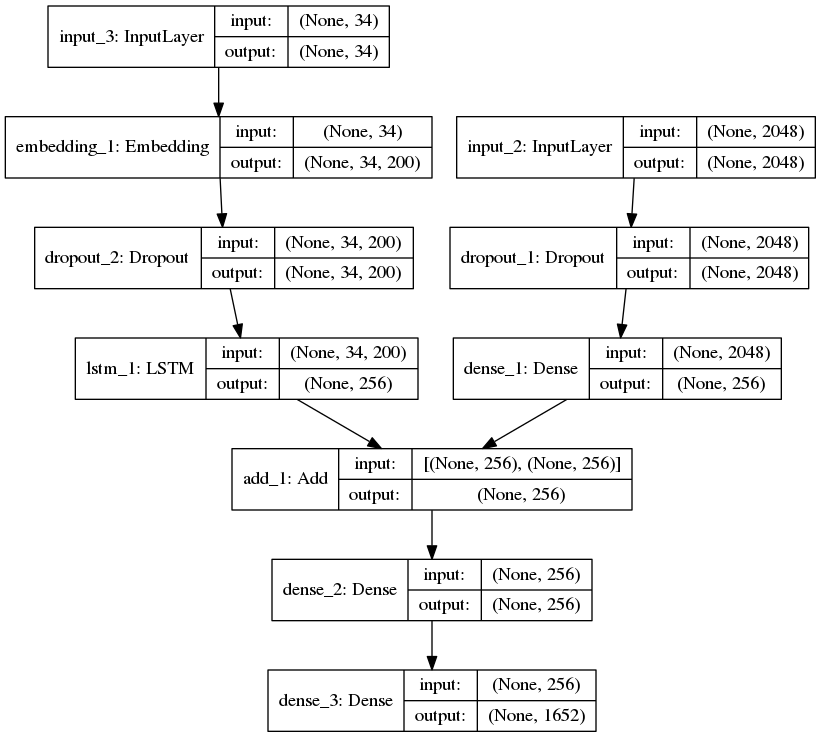

In [42]:
# image feature extractor model, inputs image feature vector

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.2)(input_img_fea)
inp_img2 = Dense(256,activation='relu')(inp_img1)


In [43]:
#partial caption sequence model, inputs captions
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=200,mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.2)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [44]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#Merge 2 networks
model = Model(inputs=[input_img_fea,input_cap],outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      369600      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [45]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False


## 3. Compile and run the model in batches

In [46]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

In [47]:
model.optimizer.lr = 0.001
epochs = 30
number_pics_per_bath = 4
steps = len(train_descriptions)//number_pics_per_bath


In [50]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_bath)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save('v3/models/model_'+str(i)+'.h5')

C:\Users\vs889\AppData\Local\Temp\ipykernel_14668\479683529.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps)


1500/1500 [==============================] - 386s 257ms/step - loss: 2.0169


## 4. Saving the best model

In [48]:
model_ = load_model('./models/model_30.h5')

## PREDICTIONS

## 1. Load the model

In [49]:
#model = load_model('v_3/models/model_30.h5')

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

## 2. Defining functions for predictions

In [50]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred = model_.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += ' '+word
    
        if word == 'endseq':
            break

    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption

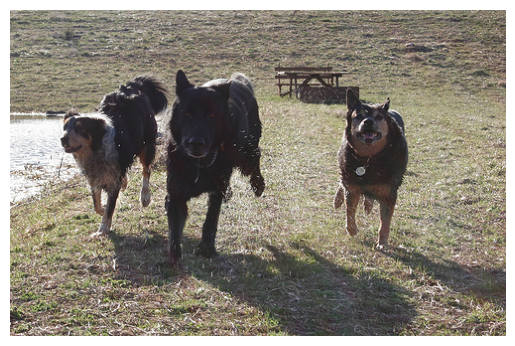

1/1 [==============================] - 0s 54ms/step
two dogs are running through the grass


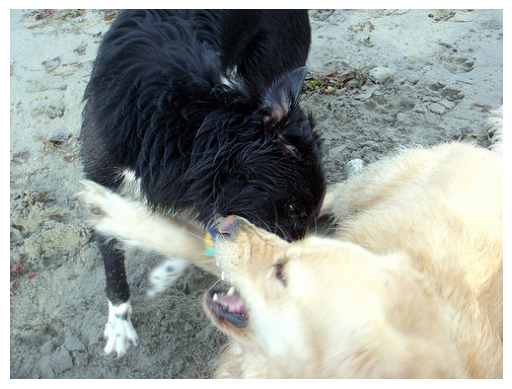

1/1 [==============================] - 0s 57ms/step
two dogs are playing in the water


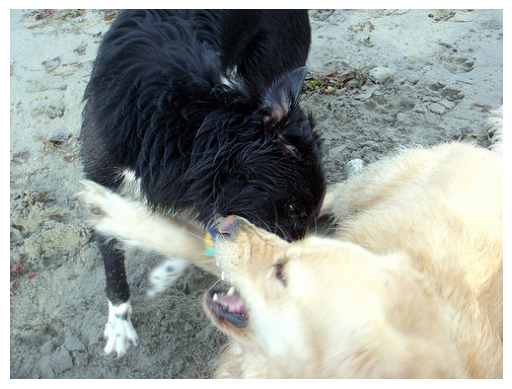

1/1 [==============================] - 0s 51ms/step
two dogs are playing in the water


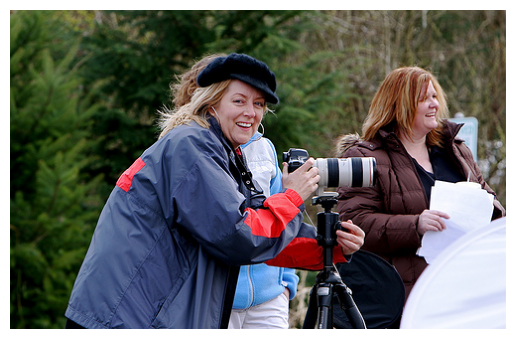

1/1 [==============================] - 0s 59ms/step
man in purple shirt and backpack is sitting on the street


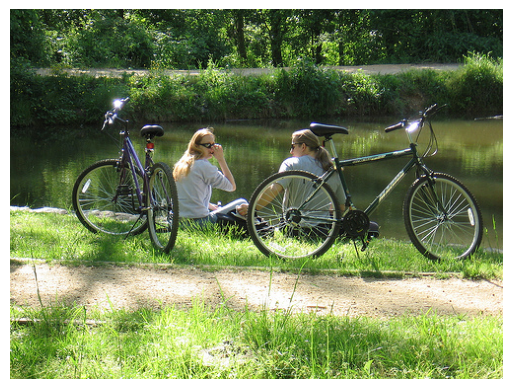

1/1 [==============================] - 0s 54ms/step
man in blue shirt and helmet riding bike down the grass


In [51]:
for i in range(5):
    rn = np.random.randint(0,332)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)

1/1 [==============================] - 0s 117ms/step


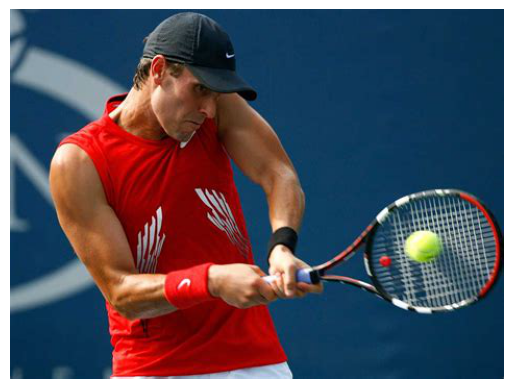

1/1 [==============================] - 0s 56ms/step
tennis player hits tennis ball


In [66]:
test_path = 'datasets/test_imgs'
n = random.randint(1, 7)
img = 'datasets/test_imgs/' + "{}.jpeg".format(n)
encodings = encode_image(img)
encodings = np.expand_dims(encodings, axis=0)
i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.show()
print(predict_caption(encodings))

1/1 [==============================] - 0s 91ms/step


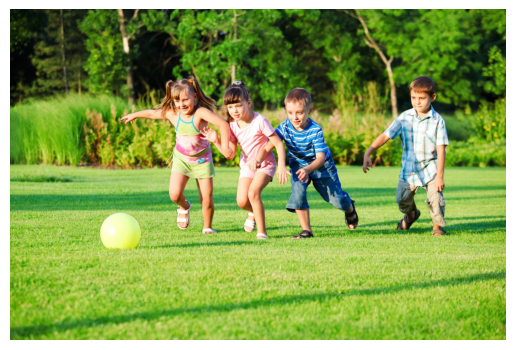

1/1 [==============================] - 0s 48ms/step
two children are playing soccer in the grass


In [46]:
model_temp = load_model('./models/model_30.h5')
test_path = 'datasets/test_imgs'
n = random.randint(1, 7)
img = 'datasets/test_imgs/' + "{}.jpeg".format(n)
encodings = encode_image(img)
encodings = np.expand_dims(encodings, axis=0)
i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.show()
in_text = "startseq"
for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
    ypred = model_temp.predict([encodings,sequence])
    ypred = ypred.argmax()
    word = idx_to_word[ypred]
    in_text += ' '+word
    if word == 'endseq':
        break

final_caption = in_text.split()
final_caption = final_caption[1:-1]
final_caption = ' '.join(final_caption)
print(final_caption)